In [25]:
!pip install stable_baselines3
!pip install gymnasium
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git
!pip install yfinance

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  Cloning https://github.com/AI4Finance-Foundation/FinRL.git to /tmp/pip-req-build-d_eupaqu
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/FinRL.git /tmp/pip-req-build-d_eupaqu
  Resolved https://github.com/AI4Finance-Foundation/FinRL.git to commit 453349afc2ee5eac8cc7f5766638c50f595df2d0
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-dwolg_oy/elegantrl_baef9aa03824475e9a3bddda4f0b238f
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-install-dwolg_oy/elegantrl_baef9aa03824475e9a3bddda4f0b238f
  Resolved https://github.com/AI4Finance-Foundation/ElegantRL.git to commit b4b9d662b9f9cb7cc368ac2b1036b5119eb20be4
  Preparing metadata (setup.py) ... done
  Using cached alpaca_trade_api-3.0.2-py3-none-any.w

In [26]:
import os
path = '/content/drive/MyDrive/Stock-Trading-Ensemble-Model'
# Write the path to the folder to our project since it include all files needed
os.chdir(path)

In [27]:
!ls

Agents.py	 EsembleAgent.py  model_0.zip  model_3.zip  model_6.zip		  README.md
DataRetrieve.py  Evaluation.py	  model_1.zip  model_4.zip  Pre_ProcessdFile.csv  stockEnv.py
Demo.ipynb	 LICENSE	  model_2.zip  model_5.zip  __pycache__


In [28]:
def data_split(df, start, end, target_date_col="date"):
    """
    split the dataset into training or testing using date
    :param data: (df) pandas dataframe, start, end
    :return: (df) pandas dataframe
    """
    data = df[(df[target_date_col] >= start) & (df[target_date_col] < end)]
    data = data.sort_values([target_date_col, "tic"], ignore_index=True)
    data.index = data[target_date_col].factorize()[0]
    return data

In [29]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
from stable_baselines3 import A2C, PPO, DDPG
from stockEnv import StockEnvMine
from Evaluation import RetrieveBenchmark

In [30]:
df = pd.read_csv("Pre_ProcessdFile.csv")

In [31]:
dic = {"ppo": PPO, "a2c": A2C, "ddpg": DDPG}
lis = ["a2c", "a2c", "ddpg", "a2c", "a2c", "ddpg"]
models = []
for i in lis:
    model = dic[i].load("model_{}".format(lis.index(i) + 1))
    models.append(model)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/save_util.py:166: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
Exception: Can't get attribute '_function_setstate' on <module 'cloudpickle.cloudpickle' from '/usr/local/lib/python3.10/dist-packages/cloudpickle/cloudpickle.py'>
  warnings.warn(


In [32]:
INDICATORS = ['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [33]:
last_state = None
initial = True
deterministic = True
account_list = []
actions_list = []
val_start = ['2022-04-04', '2022-07-06', '2022-10-04', '2023-01-04', '2023-04-05', '2023-07-07']
val_end = ['2022-07-06', '2022-10-04', '2023-01-04', '2023-04-05', '2023-07-07', '2023-08-30']
stock_dimension = len(df.tic.unique())
state_space = 1 + 2*stock_dimension + 8 *stock_dimension
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension
InitialAmount = 1000000
reward_scaling = 1e-4
env_kwargs = {
    "hmax": 100,
    "initial_amount": InitialAmount,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": reward_scaling
}
print("""There are {} stocks in the dataset.
The state space we used for training is {}.
The indicators we used is {}.
The reward scaling is {}.
The initial amount is {}.
The share for each storck in the beginning is 0.
Cost of buying and selling is 0.001.
    """.format(stock_dimension, state_space, INDICATORS, reward_scaling, InitialAmount))

There are 29 stocks in the dataset.
The state space we used for training is 291.
The indicators we used is ['macd', 'boll_ub', 'boll_lb', 'rsi_30', 'cci_30', 'dx_30', 'close_30_sma', 'close_60_sma'].
The reward scaling is 0.0001.
The initial amount is 1000000.
The share for each storck in the beginning is 0.
Cost of buying and selling is 0.001.
    


In [34]:
for i in range(len(models)):
    trade_data = data_split(df, start=val_start[i], end=val_end[i],)
    trade_env = StockEnvMine(df=trade_data, turbulence_th=None, iteration=iter, mode="", model_name="", last_state=last_state, initial=initial, **env_kwargs)
    env, obs = trade_env.getDummyEnv()
    account_memory = None
    actions_memory = None
    env.reset()
    max_step = len(trade_env.df.index.unique()) - 1
    for j in range(max_step + 1):
        action, states = models[i].predict(obs, deterministic=deterministic)
        obs, rewards, dones, info = env.step(action)
        if j == max_step - 1:
            account_memory = env.env_method(method_name="saveAssetMemory")
            actions_memory = env.env_method(method_name="saveActionMemory")
            last_state = env.envs[0].render()
        if dones[0]:
            print("Finished")
            break
    if i == 0:
        initial = False
    account_list.append(account_memory[0])
    actions_list.append(actions_memory[0])
a_new = pd.concat(account_list, ignore_index=True)
indexes = a_new.index[a_new['account_value'] == 1000000].tolist()[-3:]
for i in indexes:
    a_new.loc[i, 'account_value'] = a_new.loc[i-1, 'account_value']

day: 62, episode: 2
begin_total_asset: 1000000.00
end_total_asset: 953728.16
total_reward: -46271.84
total_cost: 1062518.92
total_trades: 837
Sharpe: -0.814
Finished
day: 62, episode: 2
begin_total_asset: 1000000.00
end_total_asset: 942405.33
total_reward: -57594.67
total_cost: 0.00
total_trades: 851
Sharpe: -1.160
Finished
day: 62, episode: 2
begin_total_asset: 1000000.00
end_total_asset: 1138725.23
total_reward: 138725.23
total_cost: 495160.37
total_trades: 1074
Sharpe: 2.952
Finished
day: 62, episode: 2
begin_total_asset: 1000000.00
end_total_asset: 1132177.92
total_reward: 132177.92
total_cost: 347303.62
total_trades: 844
Sharpe: 1.623
Finished
day: 62, episode: 2
begin_total_asset: 1000000.00
end_total_asset: 1120217.12
total_reward: 120217.12
total_cost: 0.00
total_trades: 806
Sharpe: 1.592
Finished
day: 37, episode: 2
begin_total_asset: 1000000.00
end_total_asset: 1184481.30
total_reward: 184481.30
total_cost: 1308.40
total_trades: 630
Sharpe: 3.684
Finished


In [35]:
indexes = a_new.index[a_new['account_value'] == 1000000].tolist()[-3:]
for i in indexes:
    a_new.loc[i, 'account_value'] = a_new.loc[i-1, 'account_value']

In [36]:
a_new.set_index('date', inplace=True)
a_new.index = pd.to_datetime(a_new.index)
dji = RetrieveBenchmark()

[*********************100%%**********************]  1 of 1 completed


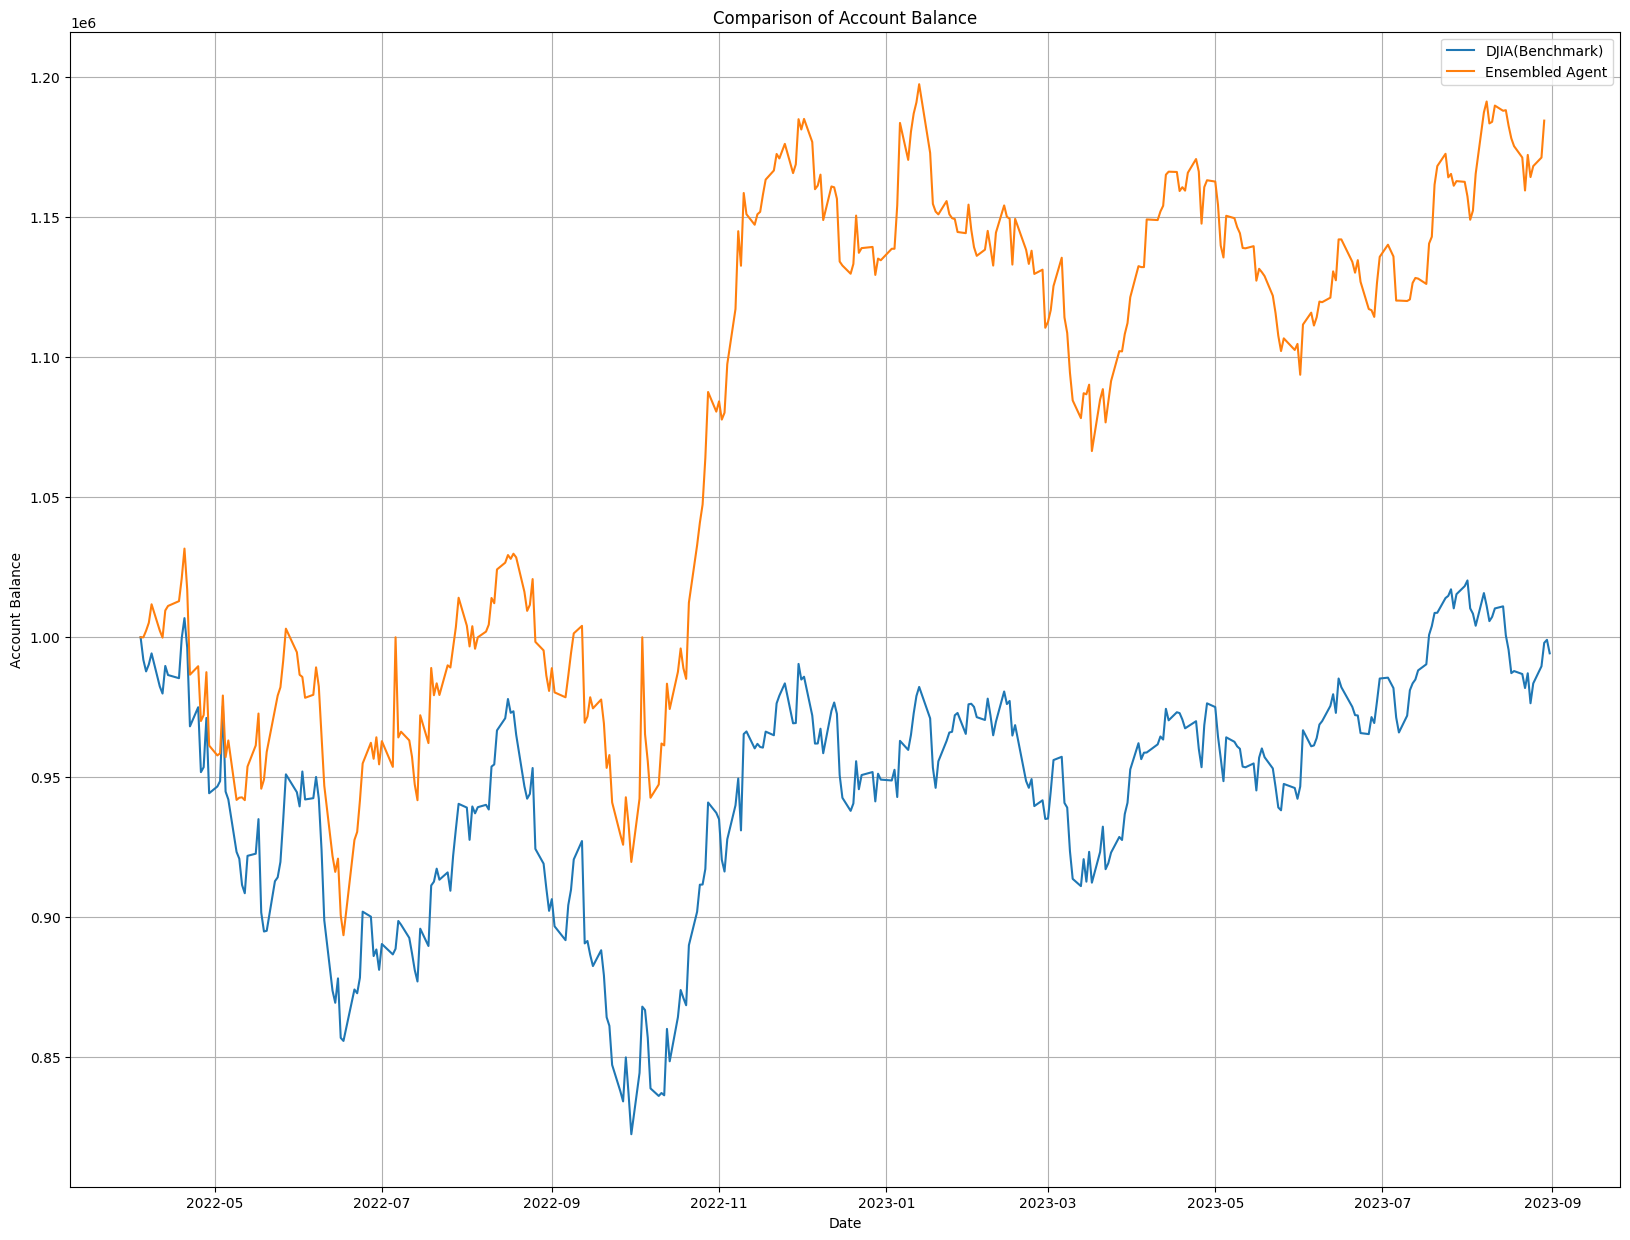

In [37]:
%matplotlib inline
plt.figure(figsize=(20, 15))

# Plot each DataFrame
plt.plot(dji['adjusted_value'], label='DJIA(Benchmark)')
plt.plot(a_new['account_value'], label='Ensembled Agent')

# Adding titles and labels
plt.title('Comparison of Account Balance')
plt.xlabel('Date')
plt.ylabel('Account Balance')

# Add a legend
plt.legend()
plt.grid()
# Show the plot
plt.show()